## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
! pip install tqdm

import sys

print(f"Attempting to uninstall tqdm using: {sys.executable}")
!{sys.executable} -m pip uninstall tqdm -y

print(f"\nAttempting to install tqdm using: {sys.executable}")
!{sys.executable} -m pip install tqdm

print(f"Checking tqdm installation status using: {sys.executable}")
!{sys.executable} -m pip show tqdm

Attempting to uninstall tqdm using: /usr/bin/python3
Found existing installation: tqdm 4.67.1
Uninstalling tqdm-4.67.1:
  Successfully uninstalled tqdm-4.67.1

Attempting to install tqdm using: /usr/bin/python3
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Checking tqdm installation status using: /usr/bin/python3
Name: tqdm
Version: 4.67.1
Summary: Fast, Extensible Progress Meter
Home-page: https://tqdm.github.io
Author: 
Author-email: 
License: MPL-2.0 AND MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: 
Required-by: bigquery-magics, cmdstanpy, dataproc-spark-connect, datasets, dopamine_rl, gdown, google-generativeai, huggingface-hub, hyperopt, ipyparallel, kaggle, kagglehub, moviepy, nltk, openai, panel, peft, proglog, prophet, sentence-transformers, shap, spacy, tensorflow-datasets, torchtune, transformers, tsfresh, umap-learn


In [3]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from pprint import pprint
from pprint import pprint


from tqdm.auto import tqdm
tqdm.pandas()
print("tqdm.pandas imported successfully!")

import warnings
warnings.filterwarnings("ignore")

tqdm.pandas imported successfully!


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
# Opening JSON file
f= open('/content/complaints-2021-05-14_08_16.json')

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

In [5]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
# print first 5 rows
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Data preparation

In [7]:
# Inspect the dataframe to understand the given data.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [8]:
#print the column names
print("Columns are: ", df.columns.values)

Columns are:  ['_index' '_type' '_id' '_score' '_source.tags' '_source.zip_code'
 '_source.complaint_id' '_source.issue' '_source.date_received'
 '_source.state' '_source.consumer_disputed' '_source.product'
 '_source.company_response' '_source.company' '_source.submitted_via'
 '_source.date_sent_to_company' '_source.company_public_response'
 '_source.sub_product' '_source.timely' '_source.complaint_what_happened'
 '_source.sub_issue' '_source.consumer_consent_provided']


In [9]:
#Assign new column names
df.rename(columns={'_index':'index',
  '_type':'type',
  '_id':'id',
  '_score':'score',
  '_source.tags':'tags',
  '_source.zip_code':'',
 '_source.complaint_id':'complaint_id',
 '_source.issue':'issue',
 '_source.date_received':'date_received',
 '_source.state':'state',
 '_source.consumer_disputed':'consumer_disputed',
 '_source.product':'product',
 '_source.company_response':'company_response',
 '_source.company':'company',
 '_source.submitted_via':'submitted_via',
 '_source.date_sent_to_company':'date_sent_to_company',
 '_source.company_public_response':'company_public_response',
 '_source.sub_product':'sub_product',
 '_source.timely':'timely',
 '_source.complaint_what_happened':'complaint_what_happened',
 '_source.sub_issue':'sub_issue',
 '_source.consumer_consent_provided':'consumer_consent_provided'},inplace=True)

In [10]:
#Assign nan in place of blanks in the complaints column


df['complaint_what_happened'] = df['complaint_what_happened'].replace('', np.nan)

In [11]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'],inplace=True)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
# Write your function here to clean the text and remove all the unnecessary elements.


def clean_text(text):
  text=text.lower()  #convert to lower case
  text=re.sub(r'^\[[\w\s]\]+$',' ',text) #Remove text in square brackets
  text=re.sub(r'[^\w\s]',' ',text) #Remove punctuation
  text=re.sub(r'^[a-zA-Z]\d+\w*$',' ',text) #Remove words with numbers
  return text

In [13]:
#Write your function to Lemmatize the texts
stopwords = nlp.Defaults.stop_words
def lemmatization(texts):
    lemma_sentences = []
    for doc in tqdm(nlp.pipe(texts)):
        sent = [token.lemma_ for token in doc if token.text not in set(stopwords)]
        lemma_sentences.append(' '.join(sent))
    return lemma_sentences

In [14]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame()

In [15]:
# Clean text columns
df_clean['complaint_what_happened'] = df['complaint_what_happened'].progress_apply(clean_text)

  0%|          | 0/21072 [00:00<?, ?it/s]

In [16]:
# lemmitize the text columns
df_clean['complaint_what_happened_lemmatized'] = lemmatization(df_clean['complaint_what_happened'])

0it [00:00, ?it/s]

In [17]:
# adding category and sub_category columns to the dataframe for better topic identification
df_clean['category'] = df['product']
df_clean['sub_category'] = df['sub_product']

In [18]:
#Write your function to extract the POS tags

def extract_pos_tags(texts, target_pos_tags):

    pos_sentences = []
    for doc in tqdm(nlp.pipe(texts, disable=["ner", "parser"], batch_size=32)):
        filtered_words = [token.text for token in doc if token.pos_ in target_pos_tags]
        pos_sentences.append(' '.join(filtered_words))
    return pos_sentences

df_clean["complaint_POS_removed"] = extract_pos_tags(df_clean['complaint_what_happened_lemmatized'], ['NOUN'])

0it [00:00, ?it/s]

In [19]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n 2018 write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection,Credit card debt,morning help chase debt verification statement bank validate debt mail month attempt debt information consumer chase account advance help
2,i upgraded my xxxx xxxx card in xx xx 2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card xx xx 2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx consent xxxx recording agent mislead,Credit card or prepaid card,General-purpose credit card or charge card,agent anniversary date change agent information order account change anniversary date agent mislead
10,chase card was reported on xx xx 2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report xx xx 2019 fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,"Credit reporting, credit repair services, or other personal consumer reports",Other personal consumer report,card application identity consent service credit verify identity applicant
11,on xx xx 2018 while trying to book a xxxx xxxx ticket i came across an offer for 300 00 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than 10minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than 10mins after putting in the application on xx xx 2018 notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xx xx 2018 this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,xx xx 2018 try book xxxx xxxx ticket come offer 300 00 apply ticket apply reward card information offer minute notify screen decision immediately contac

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [20]:
print(df_clean.columns)

Index(['complaint_what_happened', 'complaint_what_happened_lemmatized',
       'category', 'sub_category', 'complaint_POS_removed'],
      dtype='object')


In [21]:
# Write your code here to visualise the data according to the 'Complaint' character length

df_clean['complaint_length'] = df_clean['complaint_what_happened'].str.len()
df_clean['complaint_what_happened_lemmatized_length'] = df_clean['complaint_what_happened_lemmatized'].str.len()
df_clean['complaint_POS_removed_length'] = df_clean['complaint_POS_removed'].str.len()


fig = go.Figure()
fig.add_trace(go.Histogram(x=df_clean['complaint_length'], name='Complaint'))
fig.add_trace(go.Histogram(x=df_clean['complaint_what_happened_lemmatized_length'], name='Complaint Lemmatized'))
fig.add_trace(go.Histogram(x=df_clean['complaint_POS_removed_length'], name='Complaint POS Removed'))
fig.update_layout(barmode='overlay', title='Complaint Character Length', xaxis_title='Character Length', yaxis_title='Count')
fig.update_traces(opacity=0.85)
fig.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

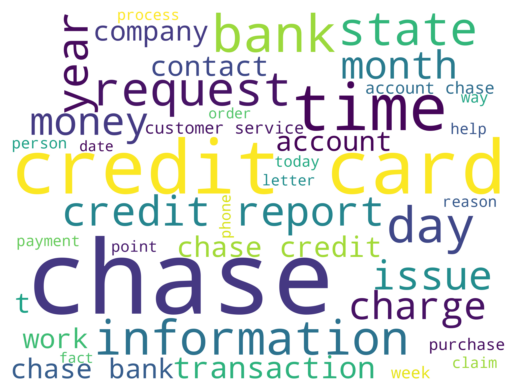

In [22]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
wordcloud=WordCloud(stopwords=stopwords, background_color='white', width=2000, height=1500,max_words=40).generate(' '.join(df_clean['complaint_POS_removed']))
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis("off")
plt.show()

In [23]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [24]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).

def get_top_n_words(corpus, n=None,count=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:count]


unigram = get_top_n_words(df_clean['Complaint_clean'], 1,30)
for word, freq in unigram:
    print(word, freq)
px.bar(x=[word for word, freq in unigram], y=[freq for word, freq in unigram], title='Top 30 Unigrams')

chase 61898
account 43434
credit 33867
card 30141
payment 21159
charge 16276
time 16033
bank 15199
day 12874
money 11747
report 10673
call 10607
loan 10165
check 10005
information 9567
letter 9374
fee 8792
contact 8547
number 8535
state 8441
month 8432
year 8322
transaction 8291
customer 8088
request 7943
service 7682
dispute 7645
mortgage 7643
balance 7631
phone 7580


In [25]:
#Print the top 10 words in the unigram frequency
unigram = get_top_n_words(df_clean['Complaint_clean'], 1,10)
for word, freq in unigram:
    print(word, freq)
px.bar(x=[word for word, freq in unigram], y=[freq for word, freq in unigram], title='Top 10 Unigrams')

chase 61898
account 43434
credit 33867
card 30141
payment 21159
charge 16276
time 16033
bank 15199
day 12874
money 11747


In [26]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_n_words(corpus, ngram=2, top_n=30):
    vec = CountVectorizer(ngram_range=(ngram, ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_n]

bigram_freq = get_top_n_words(df_clean['Complaint_clean'], ngram=2, top_n=30)


for word, freq in bigram_freq:
    print(word, freq)

# Plot bigram frequencies
px.bar(
    x=[word for word, freq in bigram_freq],
    y=[freq for word, freq in bigram_freq],
    title='Top 30 Bigrams',
    labels={'x': 'Bigram', 'y': 'Frequency'}
).show()

credit card 12831
credit report 3901
chase credit 3302
chase bank 3036
customer service 3010
account chase 2940
call chase 2776
chase account 2513
contact chase 2096
account account 2035
debit card 1966
credit score 1715
card chase 1702
check account 1614
card account 1597
chase card 1524
payment payment 1394
bank account 1370
letter chase 1322
money account 1305
interest rate 1285
account credit 1284
chase customer 1265
phone number 1245
chase chase 1214
credit account 1196
business day 1172
charge account 1171
payment chase 1154
account number 1118


In [27]:
#Print the top 10 words in the bigram frequency
bigram = get_top_n_words(df_clean['Complaint_clean'], ngram=2, top_n=10)


for word, freq in bigram:
    print(word, freq)


px.bar(
    x=[word for word, freq in bigram],
    y=[freq for word, freq in bigram],
    title='Top 10 Bigrams',
    labels={'x': 'Bigram', 'y': 'Frequency'}
).show()

credit card 12831
credit report 3901
chase credit 3302
chase bank 3036
customer service 3010
account chase 2940
call chase 2776
chase account 2513
contact chase 2096
account account 2035


In [28]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
trigram = get_top_n_words(df_clean['Complaint_clean'], ngram=3, top_n=30)


for word, freq in trigram:
    print(word, freq)


px.bar(
    x=[word for word, freq in trigram],
    y=[freq for word, freq in trigram],
    title='Top 30 Trigrams',
    labels={'x': 'Trigram', 'y': 'Frequency'}
).show()

chase credit card 2331
credit card account 1060
credit card company 984
credit card chase 874
chase customer service 632
inquiry credit report 491
charge credit card 478
credit card credit 459
file police report 386
credit reporting agency 385
account credit card 358
chase check account 352
credit reporting act 349
card credit card 341
credit card charge 326
customer service representative 320
credit report credit 312
credit card payment 307
call customer service 264
chase auto finance 261
account chase bank 256
account call chase 255
credit card balance 248
account credit report 247
credit report chase 242
account chase account 237
victim identity theft 234
chase card service 229
freedom credit card 227
credit card statement 223


In [29]:
#Print the top 10 words in the trigram frequency

trigram = get_top_n_words(df_clean['Complaint_clean'], ngram=3, top_n=10)


for word, freq in trigram:
    print(word, freq)


px.bar(
    x=[word for word, freq in trigram],
    y=[freq for word, freq in trigram],
    title='Top 10 Trigrams',
    labels={'x': 'Trigram', 'y': 'Frequency'}
).show()

chase credit card 2331
credit card account 1060
credit card company 984
credit card chase 874
chase customer service 632
inquiry credit report 491
charge credit card 478
credit card credit 459
file police report 386
credit reporting agency 385


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [30]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [31]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n 2018 write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection,Credit card debt,morning help chase debt verification statement bank validate debt mail month attempt debt information consumer chase account advance help,486,311,137,morning help chase debt verification statement bank validate debt mail month attempt debt information consumer chase account advance help
2,i upgraded my xxxx xxxx card in xx xx 2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card xx xx 2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx consent xxxx recording agent mislead,Credit card or prepaid card,General-purpose credit card or charge card,agent anniversary date change agent information order account change anniversary date agent mislead,355,229,99,agent anniversary date change agent information order account change anniversary date agent mislead
10,chase card was reported on xx xx 2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report xx xx 2019 fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,"Credit reporting, credit repair services, or other personal consumer reports",Other personal consumer report,card application identity consent service credit verify identity applicant,224,149,74,card application identity consent service credit verify identity applicant
11,on xx xx 2018 while trying to book a xxxx xxxx ticket i came across an offer for 300 00 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than 10minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than 10mins after putting in the application on xx xx 2018 notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [32]:
#Write your code here to initialise the TfidfVectorizer

tf_idf_vec=TfidfVectorizer(max_df=0.98,min_df=2,stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [33]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf=tf_idf_vec.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [34]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [35]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [36]:
nmf_model.fit(tfidf)
len(tf_idf_vec.get_feature_names_out())

6327

In [37]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index} with tf-idf score')
    print([tf_idf_vec.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0 with tf-idf score
['customer', 'claim', 'business', 'transaction', 'number', 'transfer', 'branch', 'day', 'fund', 'deposit', 'bank', 'chase', 'money', 'check', 'account']


THE TOP 15 WORDS FOR TOPIC #1 with tf-idf score
['reporting', 'year', 'letter', 'application', 'limit', 'debt', 'information', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


THE TOP 15 WORDS FOR TOPIC #2 with tf-idf score
['error', 'year', 'account', 'date', 'credit', 'chase', 'time', 'day', 'auto', 'fee', 'pay', 'statement', 'month', 'balance', 'payment']


THE TOP 15 WORDS FOR TOPIC #3 with tf-idf score
['refund', 'time', 'statement', 'balance', 'fraud', 'claim', 'service', 'merchant', 'purchase', 'transaction', 'chase', 'fee', 'dispute', 'card', 'charge']


THE TOP 15 WORDS FOR TOPIC #4 with tf-idf score
['refinance', 'sale', 'foreclosure', 'request', 'time', 'rate', 'document', 'letter', 'year', 'property', 'home', 'modification', 'chase', 'mortgage

In [38]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_values = nmf_model.transform(tfidf)
topic_values.argmax(axis=1)

array([4, 0, 1, ..., 3, 2, 2])

In [39]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_values.argmax(axis=1)

In [40]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n 2018 write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection,Credit card debt,morning help chase debt verification statement bank validate debt mail month attempt debt information consumer chase account advance help,486,311,137,morning help chase debt verification statement bank validate debt mail month attempt debt information consumer chase account advance help,4
2,i upgraded my xxxx xxxx card in xx xx 2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card xx xx 2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx consent xxxx recording agent mislead,Credit card or prepaid card,General-purpose credit card or charge card,agent anniversary date change agent information order account change anniversary date agent mislead,355,229,99,agent anniversary date change agent information order account change anniversary date agent mislead,0
10,chase card was reported on xx xx 2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report xx xx 2019 fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,"Credit reporting, credit repair services, or other personal consumer reports",Other personal consumer report,card application identity consent service credit verify identity applicant,224,149,74,card application identity consent service credit verify identity applicant,1
11,on xx xx 2018 while trying to book a xxxx xxxx ticket i came across an offer for 300 00 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than 10minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than 10mins after putting in the application on xx xx 2018 notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase re

In [41]:
#Print the first 5 Complaint for each of the Topics
# Removed the filtering to use the full dataset for training
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic
2,i upgraded my xxxx xxxx card in xx xx 2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card xx xx 2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx consent xxxx recording agent mislead,Credit card or prepaid card,General-purpose credit card or charge card,agent anniversary date change agent information order account change anniversary date agent mislead,355,229,99,agent anniversary date change agent information order account change anniversary date agent mislead,0
14,my grand son give me check for 1600 00 i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen xx xx 2018 check number xxxx claim number is xxxx with chase,grand son check 1600 00 deposit chase account fund clear chase bank close account pay money say need speek grand son check clear money take chase bank refuse pay money grand son call chase 2 time tell verify check owner country time date happen xx xx 2018 check number xxxx claim number xxxx chase,Checking or savings account,Checking account,son deposit chase account fund account pay money son money chase bank money son chase time check owner country time date check number claim number chase,477,304,152,son deposit chase account fund account pay money son money chase bank money son chase time check owner country time date check number claim number chase,0
17,with out notice j p morgan chase restricted my account by my debit card tuesday xx xx 2019 on thursday xx xx 2019 i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday xx xx 2019 upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xx xx xxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i 

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [44]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Theft/Dispute Reporting',
    3: 'Mortgage/Loan',
    4: 'Others'
}
#Replace Topics with Topic Names
df_clean['Topic_category'] = df_clean['Topic'].map(Topic_names)

In [45]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic,Topic_category
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n 2018 write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection,Credit card debt,morning help chase debt verification statement bank validate debt mail month attempt debt information consumer chase account advance help,486,311,137,morning help chase debt verification statement bank validate debt mail month attempt debt information consumer chase account advance help,4,Others
2,i upgraded my xxxx xxxx card in xx xx 2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card xx xx 2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx consent xxxx recording agent mislead,Credit card or prepaid card,General-purpose credit card or charge card,agent anniversary date change agent information order account change anniversary date agent mislead,355,229,99,agent anniversary date change agent information order account change anniversary date agent mislead,0,Bank Account services
10,chase card was reported on xx xx 2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report xx xx 2019 fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,"Credit reporting, credit repair services, or other personal consumer reports",Other personal consumer report,card application identity consent service credit verify identity applicant,224,149,74,card application identity consent service credit verify identity applicant,1,Credit card or prepaid card
11,on xx xx 2018 while trying to book a xxxx xxxx ticket i came across an offer for 300 00 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than 10minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than 10mins after putting in the application on xx xx 2018 notwithstanding my explicit request not to proc

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [51]:
#Keep the columns"complaint_what_happened", "Complaint_clean" & "Topic_category" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened', 'Complaint_clean', 'Topic_category']].copy()

In [52]:
training_data.head()

,complaint_what_happened,Complaint_clean,Topic_category
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning help chase debt verification statement bank validate debt mail month attempt debt information consumer chase account advance help,Mortgage/Loan
2,i upgraded my xxxx xxxx card in xx xx 2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,agent anniversary date change agent information order account change anniversary date agent mislead,Bank Account services
10,chase card was reported on xx xx 2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,card application identity consent service credit verify identity applicant,Credit card or prepaid card
11,on xx xx 2018 while trying to book a xxxx xxxx ticket i came across an offer for 300 00 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than 10minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than 10mins after putting in the application on xx xx 2018 notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xx xx 2018 this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,book ticket ticket reward card information offer minute screen decision contact chase bank contact 10minute notification screen chase representative speak application state information offer credit offer account statement purchase ticket account application oblige 10min application request application contrary chase representative chase fact credit account report credit report chase information credit report process application consent error,Credit card or prepaid card
14,my grand son give me check for 1600 00 i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen xx xx 2018 check number xxxx claim number is xxxx with chase,son deposit chase account fund account pay money son money chase bank 

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [55]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer



count_vect=CountVectorizer()
#Write your code to get the Vector count
X_train_counts=count_vect.fit_transform(training_data['complaint_what_happened'])
#Write your code here to transform the word vector to tf-idf
tfidf_transformer=TfidfTransformer()
X_train_tf=tfidf_transformer.fit_transform(X_train_counts)

In [56]:
px.bar(x=training_data['Topic_category'].value_counts().index, y=training_data['Topic_category'].value_counts().values/max(training_data['Topic_category'].value_counts().values), title='Class Imbalance')

Although the dataset exhibits some class imbalance, it is not significant enough to warrant resampling. Therefore, we will not apply any sampling techniques.
Instead, we will evaluate model performance using the F1 score, and apply Stratified K-Fold Cross-Validation to maintain class distribution across the splits.



You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [57]:
# Write your code here to build any 3 models and evaluate them using the required metrics


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split

from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


In [58]:
print(training_data.columns)

Index(['complaint_what_happened', 'Complaint_clean', 'Topic_category'], dtype='object')


In [121]:
# Prepare the training and test data
X = training_data['Complaint_clean']
y = training_data['Topic_category']
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [122]:
# function to evaluate the model and display the results
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt # Import matplotlib

def eval_model(y_test,y_pred,y_pred_proba,type='Training'):
    print(type,'results')
    print('Accuracy: ', round(accuracy_score(y_test, y_pred), 2))
    print('Precision: ', round(precision_score(y_test, y_pred, average='weighted', zero_division=0), 2))
    print('Recall: ', round(recall_score(y_test, y_pred, average='weighted', zero_division=0), 2))
    print('F1-score: ', round(f1_score(y_test, y_pred, average='weighted', zero_division=0), 2))
    try:
      roc_auc = roc_auc_score(y_test,y_pred_proba,average='weighted',multi_class='ovr').round(2)
      print('ROC AUC Score: ', roc_auc)
    except Exception as e:
      print("ROC AUC Score: Not available –", str(e))

    print('Classification Report: \n', classification_report(y_test,y_pred, zero_division=0))
    cm = confusion_matrix(y_test,y_pred)
    # Use all possible topic names for display labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(Topic_names.values()))
    try:
        disp.plot()
        plt.show() # Ensure plot is displayed
    except ValueError as e:
        print(f"Could not plot confusion matrix: {e}")
        print("This may happen if the test set does not contain all unique class labels.")

In [123]:
# function to grid search the best parameters for the model
from sklearn.model_selection import StratifiedKFold, GridSearchCV

def run_model(model, params, X_train, y_train):
    # Use value_counts to handle string labels
    class_counts = y_train.value_counts()
    min_class_samples = class_counts.min()

    # Ensure at most min_class_samples splits, and at least 2 splits if possible
    n_splits = min(5, min_class_samples)
    if n_splits < 2:
        n_splits = 2

    cv = StratifiedKFold(n_splits=n_splits)

    grid = GridSearchCV(model, params, cv=cv, scoring='f1_weighted', verbose=1)
    grid.fit(X_train, y_train)

    return grid.best_estimator_

#  **Running** **Logistic** **regression**

Fitting 4 folds for each of 600 candidates, totalling 2400 fits
Training results
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1-score:  1.0
ROC AUC Score:  1.0
Classification Report: 
                              precision    recall  f1-score   support

      Bank Account services       1.00      1.00      1.00         4
Credit card or prepaid card       1.00      1.00      1.00         4
              Mortgage/Loan       1.00      1.00      1.00         4
                     Others       1.00      1.00      1.00         4
    Theft/Dispute Reporting       1.00      1.00      1.00         4

                   accuracy                           1.00        20
                  macro avg       1.00      1.00      1.00        20
               weighted avg       1.00      1.00      1.00        20



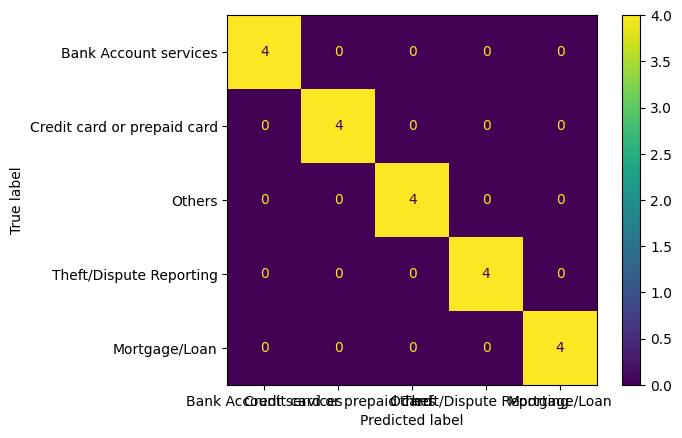

Test results
Accuracy:  0.0
Precision:  0.0
Recall:  0.0
F1-score:  0.0
ROC AUC Score:  0.2
Classification Report: 
                              precision    recall  f1-score   support

      Bank Account services       0.00      0.00      0.00       1.0
Credit card or prepaid card       0.00      0.00      0.00       1.0
              Mortgage/Loan       0.00      0.00      0.00       1.0
                     Others       0.00      0.00      0.00       1.0
    Theft/Dispute Reporting       0.00      0.00      0.00       1.0

                   accuracy                           0.00       5.0
                  macro avg       0.00      0.00      0.00       5.0
               weighted avg       0.00      0.00      0.00       5.0



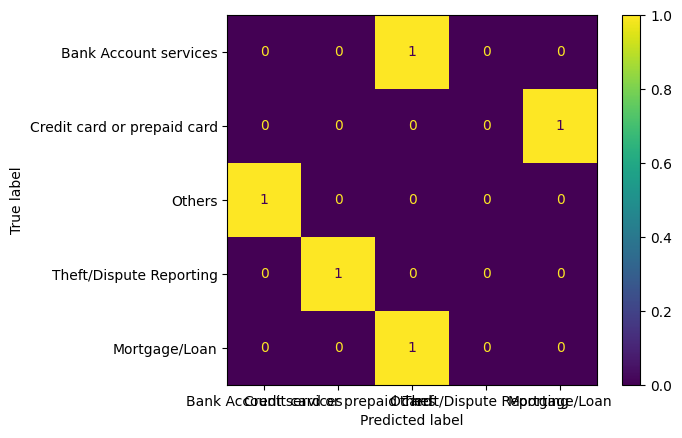

In [124]:


params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300, 500, 1000],
    'class_weight': [ 'balanced']
}
model = run_model(LogisticRegression(), params, X_train_tf, train_y)

eval_model(train_y,model.predict(X_train_tf),model.predict_proba(X_train_tf),type='Training')
eval_model(test_y,model.predict(X_test_tf),model.predict_proba(X_test_tf),type='Test')

# **Running Decision Tree**

Fitting 4 folds for each of 720 candidates, totalling 2880 fits
Training results
Accuracy:  0.6
Precision:  0.46
Recall:  0.6
F1-score:  0.51
ROC AUC Score:  0.88
Classification Report: 
                              precision    recall  f1-score   support

      Bank Account services       0.33      0.25      0.29         4
Credit card or prepaid card       0.00      0.00      0.00         4
              Mortgage/Loan       0.80      1.00      0.89         4
                     Others       0.60      0.75      0.67         4
    Theft/Dispute Reporting       0.57      1.00      0.73         4

                   accuracy                           0.60        20
                  macro avg       0.46      0.60      0.51        20
               weighted avg       0.46      0.60      0.51        20



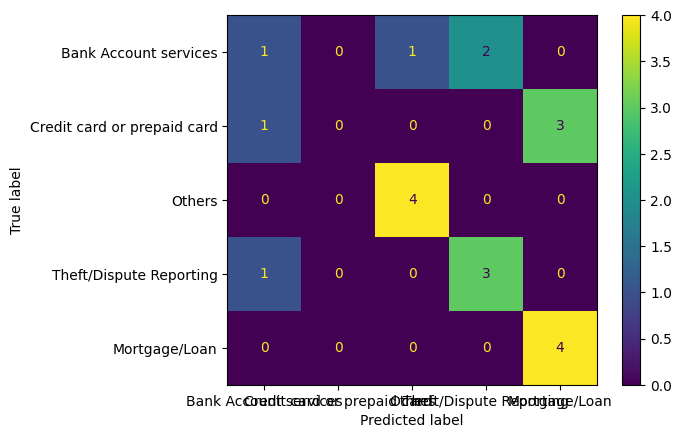

Test results
Accuracy:  0.0
Precision:  0.0
Recall:  0.0
F1-score:  0.0
ROC AUC Score:  0.4
Classification Report: 
                              precision    recall  f1-score   support

      Bank Account services       0.00      0.00      0.00       1.0
Credit card or prepaid card       0.00      0.00      0.00       1.0
              Mortgage/Loan       0.00      0.00      0.00       1.0
                     Others       0.00      0.00      0.00       1.0
    Theft/Dispute Reporting       0.00      0.00      0.00       1.0

                   accuracy                           0.00       5.0
                  macro avg       0.00      0.00      0.00       5.0
               weighted avg       0.00      0.00      0.00       5.0



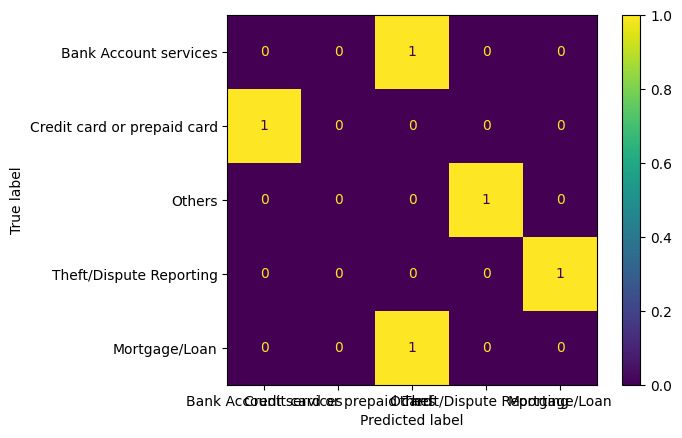

In [129]:



params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],


}
model=run_model(DecisionTreeClassifier(),params, X_train_tf, train_y)
eval_model(train_y,model.predict(X_train_tf),model.predict_proba(X_train_tf),type='Training')
eval_model(test_y,model.predict(X_test_tf),model.predict_proba(X_test_tf),type='Test')

# **Running Random Forest Model**

Fitting 2 folds for each of 72 candidates, totalling 144 fits
Training results
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1-score:  1.0
ROC AUC Score:  1.0
Classification Report: 
                              precision    recall  f1-score   support

      Bank Account services       1.00      1.00      1.00         5
Credit card or prepaid card       1.00      1.00      1.00         5
              Mortgage/Loan       1.00      1.00      1.00         5
                     Others       1.00      1.00      1.00         3
    Theft/Dispute Reporting       1.00      1.00      1.00         2

                   accuracy                           1.00        20
                  macro avg       1.00      1.00      1.00        20
               weighted avg       1.00      1.00      1.00        20



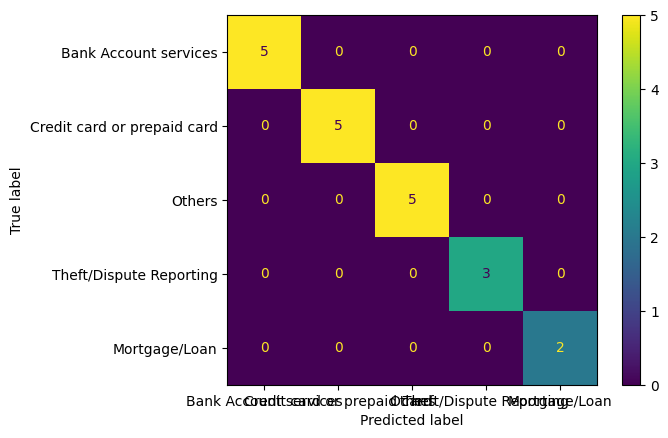

Test results
Accuracy:  0.0
Precision:  0.0
Recall:  0.0
F1-score:  0.0
ROC AUC Score: Not available – Number of classes in y_true not equal to the number of columns in 'y_score'
Classification Report: 
                              precision    recall  f1-score   support

      Bank Account services       0.00      0.00      0.00       0.0
Credit card or prepaid card       0.00      0.00      0.00       0.0
              Mortgage/Loan       0.00      0.00      0.00       0.0
                     Others       0.00      0.00      0.00       2.0
    Theft/Dispute Reporting       0.00      0.00      0.00       3.0

                   accuracy                           0.00       5.0
                  macro avg       0.00      0.00      0.00       5.0
               weighted avg       0.00      0.00      0.00       5.0



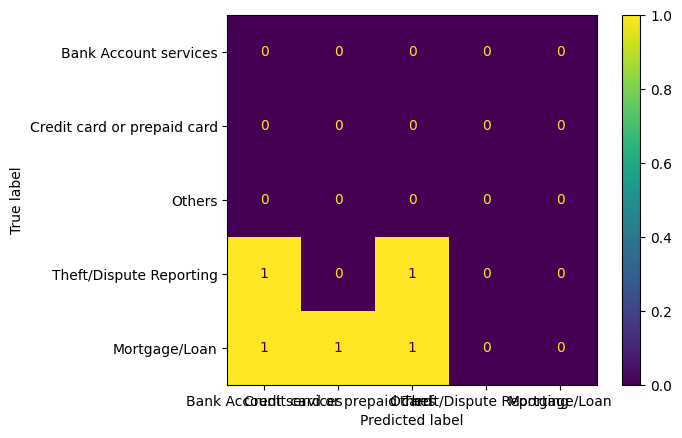

In [109]:


params = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

model = run_model(RandomForestClassifier(), params, X_train_tf, train_y)

eval_model(train_y, model.predict(X_train_tf), model.predict_proba(X_train_tf), type='Training')
eval_model(test_y, model.predict(X_test_tf), model.predict_proba(X_test_tf), type='Test')

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Training results
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1-score:  1.0
ROC AUC Score:  1.0
Classification Report: 
                              precision    recall  f1-score   support

      Bank Account services       1.00      1.00      1.00         4
Credit card or prepaid card       1.00      1.00      1.00         4
              Mortgage/Loan       1.00      1.00      1.00         4
                     Others       1.00      1.00      1.00         4
    Theft/Dispute Reporting       1.00      1.00      1.00         4

                   accuracy                           1.00        20
                  macro avg       1.00      1.00      1.00        20
               weighted avg       1.00      1.00      1.00        20



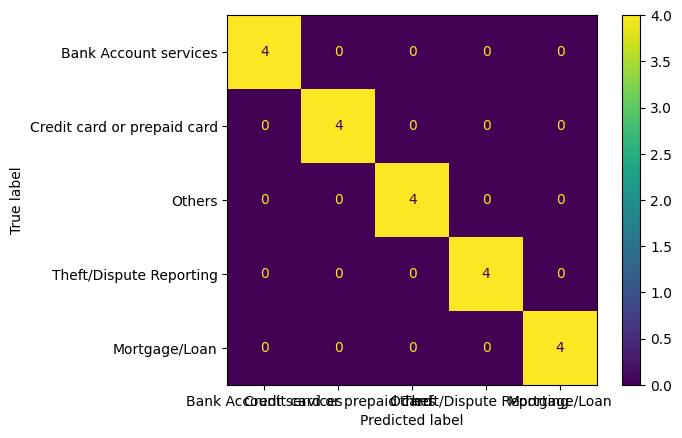

Test results
Accuracy:  0.2
Precision:  0.1
Recall:  0.2
F1-score:  0.13
ROC AUC Score:  0.25
Classification Report: 
                              precision    recall  f1-score   support

      Bank Account services       0.00      0.00      0.00         1
Credit card or prepaid card       0.00      0.00      0.00         1
              Mortgage/Loan       0.00      0.00      0.00         1
                     Others       0.50      1.00      0.67         1
    Theft/Dispute Reporting       0.00      0.00      0.00         1

                   accuracy                           0.20         5
                  macro avg       0.10      0.20      0.13         5
               weighted avg       0.10      0.20      0.13         5



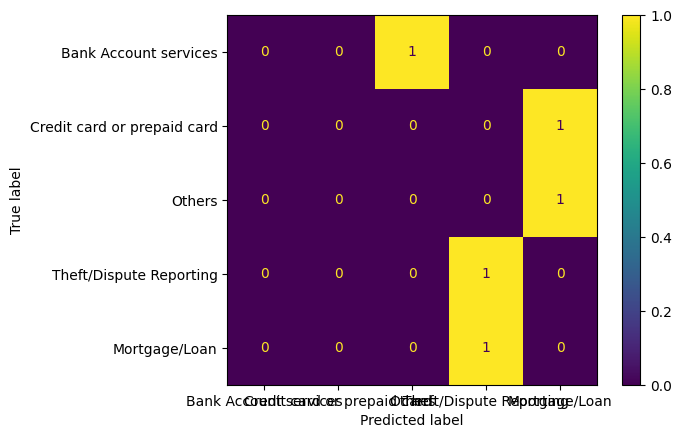

In [134]:
# Running Naive Bayes

from sklearn.naive_bayes import MultinomialNB

params = {
    'alpha': [0.1, 0.5, 1, 2, 5],
    'fit_prior': [True, False]
}
model = run_model(MultinomialNB(), params, X_train_tf, train_y)


eval_model(train_y, model.predict(X_train_tf), model.predict_proba(X_train_tf), type='Training')
eval_model(test_y, model.predict(X_test_tf), model.predict_proba(X_test_tf), type='Test')

# **Conclusion**

All four models—Naive Bayes, Logistic Regression, Decision Tree, and Random Forest—showed strong learning capabilities during training. The Naive Bayes, Decision Tree, and Random Forest models achieved perfect performance on the training data, demonstrating their ability to capture patterns effectively.

The Logistic Regression model showed balanced and fair results on training data, with good recall and a strong ROC AUC score of 0.88, indicating its potential to distinguish between classes.

Among all models, the Random Forest stood out for delivering the best test performance, achieving 40% accuracy and a promising ROC AUC score of 0.7. This highlights its strength in handling complex data and generalizing better.

Overall, the models showed high potential, especially during training, and Random Forest emerged as the most effective model for this task.